# Part 1: Implementing a CSR matrix

In [1]:
import numpy as np
import numba
from scipy.sparse.linalg import LinearOperator
# Rename to prevent name overlap
from scipy.sparse import coo_matrix as coo

class CSRMatrix(LinearOperator):
    """Class for a CSR matrix."""
    
    def __init__(self, coo_matrix):
        """Initialises a CSR matrix from a SciPy COO matrix."""
        if isinstance(coo_matrix, coo) == False:
            raise TypeError("coo_matrix must be a SciPy coo_matrix")
        # Checks that the COO matrix is consistent.
        coo_matrix._check()
        # The COO matrix's row and column orderings must be sorted row-first, or the output of the CSR matrix will be incorrect (This will never be the case if the COO matrix is created from a dense matrix).
        if len(coo_matrix.data) == 0 or np.all(coo_matrix.row[:-1] <= coo_matrix.row[1:]):
            row = coo_matrix.row
            col = coo_matrix.col
            data = coo_matrix.data
        else:
            # sort by row, then by column
            order = np.lexsort((coo_matrix.col, coo_matrix.row))
            row = coo_matrix.row[order]
            col = coo_matrix.col[order]
            data = coo_matrix.data[order]
        
        # Defines instance variables.
        self.dtype = coo_matrix.dtype
        self.shape = coo_matrix.shape
        self.data = data
        self.indices = col
        self.indptr = np.zeros(coo_matrix.shape[0] + 1, dtype=coo_matrix.row.dtype)
        
        # this calculates the number of entries in each row. the "+ 1" is due to the fact that the CSR matrix's row end is at row_index + 1. this also means that the first value of indptr is always 0.
        for row_index in row:
            self.indptr[row_index + 1] += 1
        # indptr is then the cumulative sum of the above.
        self.indptr = np.cumsum(self.indptr)
    
    def __eq__(self, other):
        """Returns whether two CSR matrices are equal (including ordering). Can work with SciPy CSR matrices as well, but only if you use self.__eq__() and not ==."""
        # Useful for testing!
        shape_eq = self.shape == other.shape
        data_eq = np.array_equal(self.data, other.data)
        indices_eq = np.array_equal(self.indices, other.indices)
        indptr_eq = np.array_equal(self.indptr, other.indptr)
        return shape_eq and data_eq and indices_eq and indptr_eq
    
    def __add__(self, other):
        """Add the CSR matrix `other` to this matrix."""
        # Should already be checked by SciPy, but just in case...
        if self.shape != other.shape:
            raise ValueError("CSR matrices must be of the same shape")

        m, n = self.shape
        # Since the class only accepts COO as input, we must convert the matrices to COO first. (The other option of returning a SciPy CSR matrix doesn't make sense programming-wise, as class types should be retained during methods like addition).
        
        # Convert CSR to COO, first by inversing the cumulative sum
        self_diff = np.diff(self.indptr)
        # Repeat the row number that many times.
        self_row = np.repeat(range(m), self_diff)
        # Do the same for the other matrix
        other_diff = np.diff(other.indptr)
        other_row = np.repeat(range(m), other_diff)
        
        # Calculate row, col, data for the resulting coo_matrix. (I would convert to COO first, then add them, but for some reason, adding two scipy coo_matrices returns a csr_matrix?)
        # A = coo(np.array([0]))
        # print(type(A+A))
        row = np.concatenate([self_row, other_row])
        col = np.concatenate([self.indices, other.indices])
        data = np.concatenate([self.data, other.data])
        out_coo = coo((data, (row, col)), shape=self.shape)
        out_coo.sum_duplicates()

        return CSRMatrix(out_coo)
    
    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def _wrapper_matvec(data, indices, indptr, shape, x):
        """Wrapper for _matvec method, which allows the method to be numba jitted (needs to be a static method as numba doesn't know what kind of data structure "self" is)."""
        # Indentical to https://tbetcke.github.io/hpc_lecture_notes/sparse_data_structures.html#csr-matrix-vector-products
        # Allowed under permission of Matthew Scroggs

        m, n = shape

        y = np.zeros(m, dtype=np.float64)

        for row_index in numba.prange(m):
            col_start = indptr[row_index]
            col_end = indptr[row_index + 1]
            for col_index in range(col_start, col_end):
                y[row_index] += data[col_index] * x[indices[col_index]]

        return y

    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        m, n = self.shape
        # Should already be checked by SciPy, but just in case...
        if vector.shape != (m,):
            raise ValueError(f"Vector has invalid shape, must be shape ({m},)")
        
        return self._wrapper_matvec(self.data, self.indices, self.indptr, self.shape, vector)

In [2]:
# random generates a random sparse matrix.
from scipy.sparse import csr_matrix, random

def test_CSR_init(repeat):
    """Tests if the __init__ function in CSRMatrix works properly."""
    for _ in range(repeat):
        coo_A = random(10, 10, density=0.2, format='coo')
        csr_A = CSRMatrix(coo_A)
        scipy_A = csr_matrix(coo_A)
        assert csr_A.__eq__(scipy_A)

def test_CSR_add(repeat):
    """Tests if the __add__ function in CSRMatrix works properly."""
    for _ in range(repeat):
        coo_A = random(10, 10, density=0.2, format='coo')
        coo_B = random(10, 10, density=0.2, format='coo')
        coo_C = coo_A + coo_B
        scipy_C = csr_matrix(coo_C)
        csr_A = CSRMatrix(coo_A)
        csr_B = CSRMatrix(coo_B)
        csr_C = csr_A + csr_B
        assert csr_C.__eq__(scipy_C)

def test_CSR_matvec(repeat):
    """Tests if the _matvec function in CSRMatrix works properly."""
    for _ in range(repeat):
        coo_A = random(10, 10, density=0.2, format='coo')
        csr_A = CSRMatrix(coo_A)
        scipy_A = csr_matrix(coo_A)
        vec = np.random.rand(10)
        assert np.array_equal(scipy_A @ vec, csr_A @ vec)

# Repeat each test 10 times, just in case.
test_CSR_init(10)
test_CSR_add(10)
test_CSR_matvec(10)
print("All good")

All good


In [3]:
from timeit import timeit

def generate_matvec(N):
    """Generate a vector, COO, CSR, and dense matrix of size N."""
    coo_A = random(N, N, density=0.1, format='coo')
    csr_A = CSRMatrix(coo_A)
    dense_A = coo_A.todense()
    vec = np.random.rand(N)
    return csr_A, dense_A, vec

def time_matvec():
    """Time it takes to compute a matrix-vector multiplication for CSR and dense formats"""
    t_csr = timeit("csr_A @ vec", "from __main__ import csr_A, vec", number=1)
    t_dense = timeit("dense_A @ vec", "from __main__ import dense_A, vec", number=1)
    return t_csr, t_dense

N_range = [2, 5, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
t_res = np.zeros((2, len(N_range)))
for i, N in enumerate(N_range):
    csr_A, dense_A, vec = generate_matvec(N)
    t_csr, t_dense = time_matvec()
    t_res[0, i] = t_csr
    t_res[1, i] = t_dense

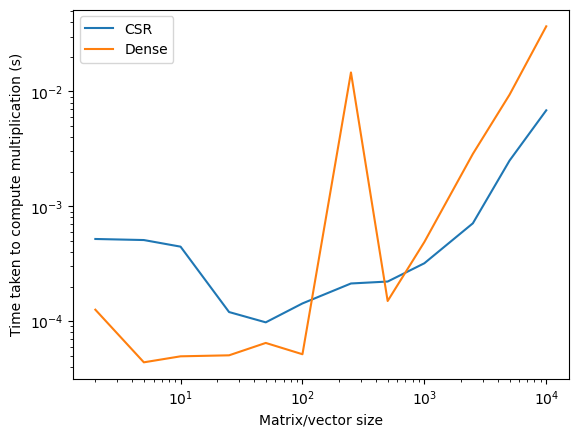

In [4]:
import matplotlib.pyplot as plt

plt.plot(N_range, t_res[0, :])
plt.plot(N_range, t_res[1, :])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Matrix/vector size")
plt.ylabel("Time taken to compute multiplication (s)")
plt.legend(["CSR", "Dense"])

We see that for lower matrix/vector sizes, CSR performs slower than for dense matrices. However, for higher matrix/vector sizes, numba's multithreading for the CSR matvec becomes more apparent, and it becomes faster than dense matrices. (I'm not sure what's up with the spike; could be that random number generator.)

In [5]:
from scipy.sparse import diags
from scipy.sparse.linalg import cg, gmres, eigs

def sparse_matvec(N):
    # Matrix obtained from the finite difference method of -y''(x). Is symmetric positive definite (see assert below).
    data = [np.full(N, 2*N**2), np.full(N-1, -N**2), np.full(N-1, -N**2)]
    A_coo = diags(data, offsets=[0, 1, -1], shape=(N, N), format='coo')
    assert np.all(eigs(A_coo)[0] > 0)
    
    A = CSRMatrix(A_coo)
    b = np.random.rand(N)
    return A, b

A, b = sparse_matvec(100)
sol_cg, _ = cg(A, b)
sol_gmres, _ = gmres(A, b)

# Residuals
res_cg = b - A @ sol_cg
res_gmres = b - A @ sol_gmres

norm of gmres' residual:  6.31288634827943e-05
norm of cg's residual:  5.863723555194606e-12


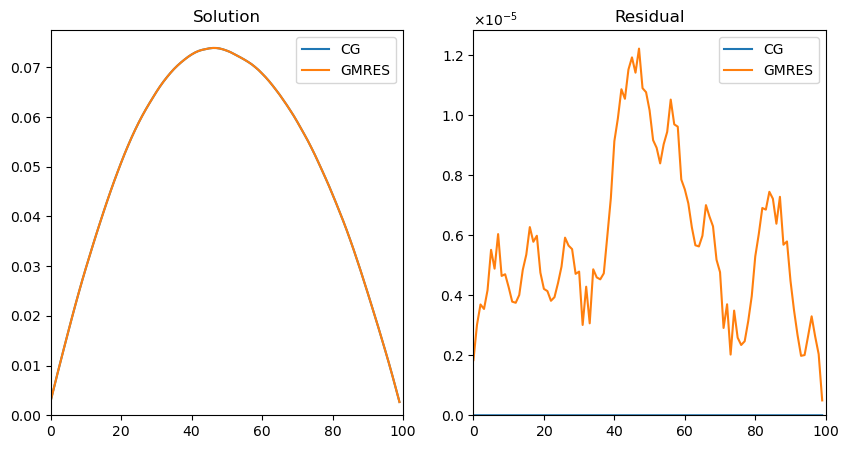

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sol_cg)
ax1.plot(sol_gmres)
ax1.set(title="Solution")
ax1.set_xlim(0,100)
ax1.set_ylim(0)
ax1.legend(["CG", "GMRES"])

ax2.plot(res_cg)
ax2.plot(res_gmres)
ax2.set(title="Residual")
ax2.set_xlim(0,100)
ax2.set_ylim(0)
ax2.ticklabel_format(useMathText=True)
ax2.legend(["CG", "GMRES"])

fig.set_size_inches(10,5)

print("norm of gmres' residual: ", np.linalg.norm(res_gmres))
print("norm of cg's residual: ", np.linalg.norm(res_cg))

We see that the two solutions are very close to each other, but are not exactly the same (norm of residuals differ by about $6\times 10^5$ — note that CG's residual is the blue line at the very bottom).

This is because GMRES works for all matrices $\mathbf{A}$, but CG only works on, and is suited to, symmetric positive definite matrices, of which the matrix we used is one (alternatively, the results may be different if the system of equations has no or many solutions). Their iterations and methodologies are also different: GMRES minimises the 2-norm of the residual, while CG minimises the weighted $A$-norm $||\boldsymbol{x}||_A = \sqrt{\boldsymbol{x}^\mathsf{T}\mathbf{A}\boldsymbol{x}}$ of the error (both over the same Krylov subspace $\mathcal{K}(\mathbf{A}, \boldsymbol{b})$).

# Part 2: Implementing a custom matrix

In [7]:
class DTWMatrix(LinearOperator):
    """Class for a sparse matrix where the top-left submatrix is a diagonal matrix, the bottom-right submatrix is dense and equal to T*W, where T is a tall matrix amd W is a wide matrix, and the rest zeros."""
    
    def __init__(self, diag, tall, wide):
        """Initialises a DTW matrix from a diagonal array/matrix, tall matrix and wide matrix."""
        if tall.ndim != 2 or tall.shape[1] != 2:
            raise ValueError("tall must be a n by 2 matrix")
        if wide.ndim != 2 or wide.shape[0] != 2:
            raise ValueError("wide must be a 2 by n matrix")
        if diag.ndim >= 2:
            if not np.array_equal(np.diag(np.diag(diag)), diag):
                raise ValueError("diag must be a diagonal matrix or an array.")
            else:
                self.diag = np.diag(diag).astype(np.float64)
        else:
            self.diag = diag.astype(np.float64)
            
        if not (diag.shape[0] == tall.shape[0] == wide.shape[1]):
            raise ValueError(f"n is inconsistent (D{diag.shape[0]}/T{tall.shape[0]}/W{wide.shape[1]}). Check shape of inputs.")

        self.dtype = np.float64
        self.shape = (2*diag.shape[0], 2*diag.shape[0])
        self.tall = tall.astype(np.float64)
        self.wide = wide.astype(np.float64)
    
    def _matvec(self, vector):
        """Performs a matrix-vector multiplication."""
        n = self.shape[0]//2
        upper = self.diag * vector[:n]
        lower = (self.tall @ self.wide) @ vector[n:]
        return np.concatenate([upper, lower])
    
    def todense(self):
        """Returns the dense version of the matrix."""
        n = self.shape[0]//2
        zeros = np.zeros((n, n))
        upper = np.hstack([np.diag(self.diag), zeros])
        lower = np.hstack([zeros, self.tall @ self.wide])
        return np.vstack([upper, lower])

In [8]:
def generate_matvec2(n):
    """Generate a random DTW matrix, its equivalent dense matrix and vector of size 2n."""
    diag = np.random.rand(n)
    tall = np.random.rand(n, 2)
    wide = np.random.rand(2, n)
    dtw_A = DTWMatrix(diag, tall, wide)
    dense_A = dtw_A.todense()
    csr_A = CSRMatrix(coo(dense_A))
    vec = np.random.rand(2*n)
    return dtw_A, dense_A, csr_A, vec

def time_matvec2():
    """Time it takes to compute a matrix-vector multiplication for DTW and dense formats."""
    t_dtw = timeit("dtw_A @ vec", "from __main__ import dtw_A, vec", number=1)
    t_dense = timeit("dense_A @ vec", "from __main__ import dense_A, vec", number=1)
    t_csr = timeit("csr_A @ vec", "from __main__ import csr_A, vec", number=1)
    return t_dtw, t_dense, t_csr

n_range = [1, 2, 5, 25, 50, 100, 250, 500, 1000, 2500, 5000]
t_res2 = np.zeros((3, len(n_range)))
for i, n in enumerate(n_range):
    dtw_A, dense_A, csr_A, vec = generate_matvec2(n)
    t_dtw, t_dense, t_csr = time_matvec2()
    t_res2[0, i] = t_dtw
    t_res2[1, i] = t_dense
    t_res2[2, i] = t_csr

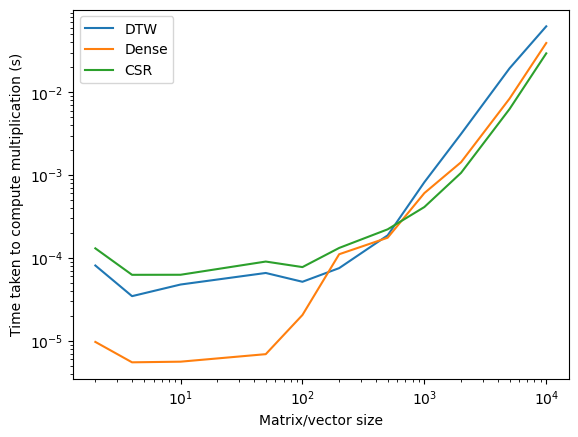

In [9]:
plt.plot(2*np.array(n_range), t_res2[0, :])
plt.plot(2*np.array(n_range), t_res2[1, :])
plt.plot(2*np.array(n_range), t_res2[2, :])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Matrix/vector size")
plt.ylabel("Time taken to compute multiplication (s)")
plt.legend(["DTW", "Dense", "CSR"])

All three data structures take similar times, but `DTWMatrix` can be seen as being slower than the other two (note that the comparison between CSR and Dense is similar to the one above; however, as the sparsity of the matrix is lower, the lines are closer together). This is likely because of the extra calculation `tall @ wide` that the `DTWMatrix` structure needs to perform, which none of the others need to do, especially becoming apparent for higher $n$ (The reason why `tall` and `wide` are stored instead of `a_tilde` is because storing `tall` and `wide` takes less memory \[$2\times 2 n$ entries\] than `a_tilde` \[$n^2$ entries\] for $n\gt 4$). Additionally, `DTWMatrix`'s `matvec` function is not numba-jitted, which also makes it slightly slower (although likely not substantially, as the code lacks parallelisation unless `@` is also jitted, like the matvec and matmat functions for the first assignment).